## 1. Data Prep

In [27]:
from __future__ import print_function
import pandas as pd
import numpy as np
np.random.seed(1337)
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Dropout, Activation, Embedding, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Concatenate
from keras.utils.np_utils import to_categorical
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.preprocessing import Normalizer, LabelEncoder, StandardScaler, OneHotEncoder
from keras import callbacks,optimizers, backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras.losses import sparse_categorical_crossentropy, categorical_crossentropy, mean_squared_error
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.utils import to_categorical
from keras.losses import BinaryCrossentropy
from keras.metrics import Precision as k_precision, Recall as k_recall
from keras.metrics import PrecisionAtRecall, TruePositives as tp, TrueNegatives as tn, FalseNegatives as fn, FalsePositives as fp
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import SVG

In [28]:
traindata = pd.read_csv('data/KDDTrain+.txt', names= ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels","difficulty"])
testdata = pd.read_csv('data/KDDTest+.txt', names= ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels","difficulty"])

In [29]:
#convert the target-normal & malacious
def cov_binary(row):
    if row["labels"] == "normal":
        return 0
    else:
        return 1

def cov_multi(row):
    DoS = ['neptune','teardrop','smurf','pod','back','land','apache2','processtable','worm','udpstorm','mailbomb']
    probe = ['ipsweep','portsweep','nmap','satan','saint','mscan']
    R2L = ['sendmail','named','httptunnel','snmpguess','snmpgetattack','warezclient','guess_passwd','ftp_write','multihop','imap','warezmaster','phf','spy','xlock','xsnoop']
    U2R = ['perl','rootkit','buffer_overflow','loadmodule','ps','xterm','sqlattack']
    if row["labels"] in DoS:
        return 1
    elif row["labels"] in probe:
        return 2
    elif row["labels"] in R2L:
        return 3
    elif row["labels"] in U2R:
        return 4
    else:
        return 0 #normal

In [30]:
#Creating "intrusion_multi" as multi-label feature for resampling
traindata["intrusion_binary"] = traindata.apply(lambda row:cov_binary(row),axis=1)
testdata["intrusion_binary"] = testdata.apply(lambda row:cov_binary(row),axis=1)
traindata["intrusion_multi"] = traindata.apply(lambda row:cov_multi(row),axis=1)
testdata["intrusion_multi"] = testdata.apply(lambda row:cov_multi(row),axis=1)

print("############binary##########################")
print(traindata.groupby("intrusion_binary").size())
print(testdata.groupby("intrusion_binary").size())
print("############multi-class##########################")
print(traindata.groupby("intrusion_multi").size())
print(testdata.groupby("intrusion_multi").size())

############binary##########################
intrusion_binary
0    67343
1    58630
dtype: int64
intrusion_binary
0     9711
1    12833
dtype: int64
############multi-class##########################
intrusion_multi
0    67343
1    45927
2    11656
3      995
4       52
dtype: int64
intrusion_multi
0    9711
1    7460
2    2421
3    2885
4      67
dtype: int64


In [31]:
for c in range(1,4):
    traindata.iloc[:,c] = LabelEncoder().fit_transform(traindata.iloc[:,c])
    testdata.iloc[:,c] = LabelEncoder().fit_transform(testdata.iloc[:,c])
train_x = traindata.iloc[:,0:41]
train_y_b = traindata.iloc[:,-2]
train_y_m = traindata.iloc[:,-1]
test_x = testdata.iloc[:,0:41]
test_y_b = testdata.iloc[:,-2]
test_y_m = testdata.iloc[:,-1]

train_x = np.array(train_x)
test_x = np.array(test_x)

train_x.astype(float)
test_x.astype(float)

scaler = Normalizer().fit(train_x)
train_x = scaler.transform(train_x)

scaler = Normalizer().fit(test_x)
test_x = scaler.transform(test_x)

train_y_b = np.array(train_y_b)
test_y_b = np.array(test_y_b)
train_y_m = np.array(train_y_m)
test_y_b = np.array(test_y_b)

## 2. Feature Selection & Re-sampling

In [33]:
def cov_multilabel(row):
    DoS = ['neptune','teardrop','smurf','pod','back','land','apache2','processtable','worm','udpstorm','mailbomb']
    probe = ['ipsweep','portsweep','nmap','satan','saint','mscan']
    R2L = ['sendmail','named','httptunnel','snmpguess','snmpgetattack','warezclient','guess_passwd','ftp_write','multihop','imap','warezmaster','phf','spy','xlock','xsnoop']
    U2R = ['perl','rootkit','buffer_overflow','loadmodule','ps','xterm','sqlattack']
    if row["labels"] in DoS:
        return "DoS"
    elif row["labels"] in probe:
        return "probe"
    elif row["labels"] in R2L:
        return "R2L"
    elif row["labels"] in U2R:
        return "U2R"
    else:
        return "normal"

traindata["intrusion_label"] = traindata.apply(lambda row:cov_multilabel(row),axis=1)
testdata["intrusion_label"] = testdata.apply(lambda row:cov_multilabel(row),axis=1)

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_train = ohe.fit_transform(traindata["intrusion_label"].to_numpy().reshape(-1, 1))
OH_valid = ohe.transform(testdata["intrusion_label"].to_numpy().reshape(-1, 1))
OH_train = pd.DataFrame(OH_train,columns=ohe.get_feature_names_out())
OH_valid = pd.DataFrame(OH_valid,columns=ohe.get_feature_names_out())

newtraindata = pd.concat([traindata, OH_train], axis=1)
newtestdata = pd.concat([testdata, OH_valid], axis=1)


In [34]:
# create multi-task metrics for multi-task feature selection
mtl_train_x = newtraindata.iloc[:,0:41]
mtl_train_y_b = newtraindata.iloc[:,-8]
mtl_train_y = newtraindata.iloc[:,-5:] #five tasks
mtl_test_x = newtestdata.iloc[:,0:41]
mtl_test_y_b = newtestdata.iloc[:,-8]
mtl_test_y = newtestdata.iloc[:,-5:]

<Figure size 720x720 with 0 Axes>

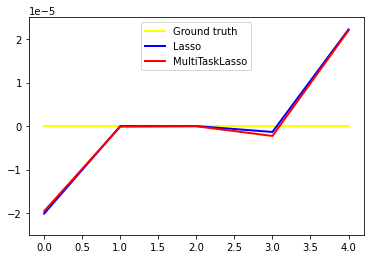

['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']


In [35]:
#Lasso - feature selection for MTL
from sklearn.linear_model import Lasso, MultiTaskLasso, MultiTaskElasticNet
import matplotlib.pyplot as plt
def multitask_lasso_selection(X,Y,col_list):
    coef_lasso_ = np.array([Lasso(alpha=0.1).fit(X, y).coef_ for y in Y.T])
    coef_multi_task_lasso_ = MultiTaskElasticNet(alpha=1.0,l1_ratio=1).fit(X, Y).coef_
    #select features
    select = []
    for i in range(len(coef_multi_task_lasso_)):
        for j in range(len(coef_multi_task_lasso_[0])):
            if coef_multi_task_lasso_[i,j] != 0 and col_list[j] not in select:
                select.append(col_list[j])
                
    #plotting
    fig = plt.figure(figsize=(10, 10))
    coef = np.zeros((len(Y[0]), len(X[0])))
    feature_to_plot = 0
    plt.figure()
    lw = 2
    plt.plot(coef[:, feature_to_plot], color="yellow", linewidth=lw, label="Ground truth")
    plt.plot(coef_lasso_[:, feature_to_plot], color="blue", linewidth=lw, label="Lasso")
    plt.plot(coef_multi_task_lasso_[:, feature_to_plot], color="red", linewidth=lw, label="MultiTaskLasso")
    plt.legend(loc="upper center")
    plt.ylim([-0.000025, 0.000025])
    plt.show()

    return(select)

multitask_lasso = multitask_lasso_selection(np.array(mtl_train_x),np.array(mtl_train_y),mtl_train_x.columns)
print(multitask_lasso)


In [36]:
mtl_train_x_lasso = mtl_train_x[multitask_lasso]
mtl_test_x_lasso = mtl_test_x[multitask_lasso]
mtl_train_x_lasso = np.array(mtl_train_x_lasso)
mtl_test_x_lasso = np.array(mtl_test_x_lasso)
mtl_train_x_lasso.astype(float)
mtl_test_x_lasso.astype(float)
scaler_lasso = Normalizer().fit(mtl_train_x_lasso)
mtl_train_x_lasso = scaler_lasso.transform(mtl_train_x_lasso)
scaler_lasso = Normalizer().fit(mtl_test_x_lasso)
mtl_test_x_lasso = scaler_lasso.transform(mtl_test_x_lasso)

mtl_train_y_b = np.array(mtl_train_y_b)
mtl_train_y = np.array(mtl_train_y)
mtl_test_y_b = np.array(mtl_test_y_b)
mtl_test_y = np.array(mtl_test_y)

In [37]:
# Resampling
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTEENN
multi_label = newtraindata.intrusion_multi.to_list()
print(sorted(Counter(train_y_m).items()))
multi_st = SMOTEENN(sampling_strategy="not minority",smote=SMOTE(random_state=42),random_state=42)
multi_x_try, multi_y_try = multi_st.fit_resample(mtl_train_x_lasso,train_y_m)
print(sorted(Counter(multi_y_try).items()))

[(0, 67343), (1, 45927), (2, 11656), (3, 995), (4, 52)]
[(0, 67203), (1, 67234), (2, 67216), (3, 67310), (4, 67342)]


In [38]:
# create 5 targets ['x0_DoS', 'x0_R2L', 'x0_U2R', 'x0_normal', 'x0_probe']
temp_mtl_y = pd.DataFrame(multi_y_try,columns=["labels"])
def cov_u2r(x):
    if x["labels"] == 4:
        return 1
    else:
        return 0
def cov_normal(x):
    if x["labels"] == 0:
        return 1
    else:
        return 0
def conv_dos(x):
    if x["labels"] == 1:
        return 1
    else:
        return 0
def cov_probe(x):
    if x["labels"] == 2:
        return 1
    else:
        return 0
def cov_r2l(x):
    if x["labels"] == 3:
        return 1
    else:
        return 0

temp_mtl_y["x0_DoS"] = temp_mtl_y.apply(lambda row:conv_dos(row),axis=1)
temp_mtl_y["X0_R2L"] = temp_mtl_y.apply(lambda row:cov_r2l(row),axis=1)
temp_mtl_y["X0_U2R"] = temp_mtl_y.apply(lambda row:cov_u2r(row),axis=1)
temp_mtl_y["X0_normal"] = temp_mtl_y.apply(lambda row:cov_normal(row),axis=1)
temp_mtl_y["X0_probe"] = temp_mtl_y.apply(lambda row:cov_probe(row),axis=1)
multi_y_try = temp_mtl_y.iloc[:,1:]
print(multi_y_try.columns)

Index(['x0_DoS', 'X0_R2L', 'X0_U2R', 'X0_normal', 'X0_probe'], dtype='object')


In [39]:
scaler_train = Normalizer().fit(multi_x_try)
multi_x_try = scaler_train.transform(multi_x_try)
scaler_test = Normalizer().fit(mtl_test_x_lasso)
mtl_test_x_lasso = scaler_test.transform(mtl_test_x_lasso)

In [40]:
print(multi_x_try.shape)
print(multi_y_try.shape)
print(mtl_test_x_lasso.shape)
print(mtl_test_y.shape)

(336305, 7)
(336305, 5)
(22544, 7)
(22544, 5)


## 3. mtl-with-keras


In [41]:
# Create task-specific vectors
for i in range(5):
    idx = ['DoS', 'R2L', 'U2R', 'normal', 'probe']
    temp_train_y = multi_y_try
    temp_train_y.columns = idx
    temp_test_y = pd.DataFrame(mtl_test_y,columns=idx)
    globals()[f"train_{idx[i]}"] = (np.array(temp_train_y[idx[i]])).astype(float)
    globals()[f"test_{idx[i]}"] = (np.array(temp_test_y[idx[i]])).astype(float)
    print(f"train_{idx[i]}")
    print(f"test_{idx[i]}")

train_DoS
test_DoS
train_R2L
test_R2L
train_U2R
test_U2R
train_normal
test_normal
train_probe
test_probe


In [83]:
def create_base_network(input_dim=7):
    inputs = Input(shape=(input_dim,1), name='inputs')
    # First Convolution
    conv1 = Conv1D(filters=256, kernel_size=5, padding='valid', activation='relu', name='conv1')(inputs)
    pool1 = MaxPooling1D(pool_size=3, name='pool1')(conv1)
    pool1 = BatchNormalization(name = 'batch_norm_1')(pool1)
    conv2 = Conv1D(filters=512, kernel_size=1, padding='same', activation='relu', name='conv2')(pool1)
    pool2 = MaxPooling1D(pool_size=1, name='pool2')(conv2)
    pool2 = BatchNormalization(name = 'batch_norm_2')(pool2)
    conv3 = Conv1D(filters=256, kernel_size=1, padding='same', activation='relu', name='conv3')(pool2)
    pool3 = MaxPooling1D(pool_size=1, name='pool3')(conv3)
    pool3 = BatchNormalization(name = 'batch_norm_3')(pool3)
    flatten = Flatten(name='flatten')(pool3)
    full = Dense(1024, activation='relu', name='full')(flatten)
    intrusion_detection = Dense(256, activation='relu', name='detection')(full)
    id_output = Dense(1, name='binary_output', activation="sigmoid")(intrusion_detection)
    model = Model(inputs=inputs, outputs=id_output)
    model.compile(Adam(learning_rate=0.0001), loss=BinaryCrossentropy(from_logits=False,label_smoothing=0.1), 
                metrics=['accuracy',k_recall(thresholds=0.5), PrecisionAtRecall(recall=0.5), tp(thresholds=0.5), tn(thresholds=0.5), fp(thresholds=0.5), fn(thresholds=0.5)])
    return model

In [60]:
def stl_callbacks():
    path_checkpoint = 'stl_checkpoint.keras'
    callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_accuracy', verbose=1, save_weights_only=True, save_best_only=True)
    callback_early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
    log_dir = 'model_logs'
    callback_tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True)
    return [callback_checkpoint, callback_early_stopping, callback_tensorboard]

In [84]:
# create binary intrusion detection task
def reverse(x):
    if x == 0:
        return 1
    else:
        return 0
reverse_result = np.vectorize(reverse)
train_binary = reverse_result(train_normal)
test_binary = reverse_result(test_normal)

model_save_file = 'lasso_elastic_mtlkeras/stl_model.h5'
stl = create_base_network()
callbacks = stl_callbacks()
stl.fit(x=multi_x_try, y=train_binary, validation_data=(mtl_test_x_lasso,test_binary), batch_size=128, epochs=10, callbacks = callbacks)
stl.save(model_save_file)

Epoch 1/10
2627/2628 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9684 - recall_16: 0.9896 - precision_at_recall_13: 0.9988 - true_positives_16: 266255.0000 - true_negatives_16: 59387.0000 - false_positives_16: 7805.0000 - false_negatives_16: 2809.0000
Epoch 1: val_accuracy improved from -inf to 0.84759, saving model to stl_checkpoint.keras
2628/2628 [==============================] - 33s 12ms/step - loss: 0.0893 - accuracy: 0.9684 - recall_16: 0.9896 - precision_at_recall_13: 0.9988 - true_positives_16: 266292.0000 - true_negatives_16: 59397.0000 - false_positives_16: 7806.0000 - false_negatives_16: 2810.0000 - val_loss: 0.8121 - val_accuracy: 0.8476 - val_recall_16: 0.7740 - val_precision_at_recall_13: 0.9655 - val_true_positives_16: 9933.0000 - val_true_negatives_16: 9175.0000 - val_false_positives_16: 536.0000 - val_false_negatives_16: 2900.0000
Epoch 2/10
2626/2628 [============================>.] - ETA: 0s - loss: 0.0596 - accuracy: 0.9797 - recall_16: 

In [85]:
pred_binary = load_model('lasso_elastic_mtlkeras/stl_model.h5')
pred_bin_class = pred_binary.predict(mtl_test_x_lasso)
print(pred_binary.evaluate(mtl_test_x_lasso,test_binary))

705/705 [==============================] - 3s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8170 - recall_17: 0.7143 - true_positives_17: 9167.0000 - true_negatives_17: 9252.0000 - false_positives_17: 459.0000 - false_negatives_17: 3666.0000
[0.0, 0.8170244693756104, 0.71433025598526, 9167.0, 9252.0, 459.0, 3666.0]


In [86]:
binary_loss, binary_accuracy, binary_recall, b_tp, b_tn, b_fp, b_fn = pred_binary.evaluate(mtl_test_x_lasso,test_binary)
#acc, precision, recall, tpr, fpr
print((b_tp+b_tn)/(b_tp+b_fp+b_tn+b_fn), b_tp/(b_tp+b_fp), b_tp/(b_tp+b_fn), b_tp/(b_tp+b_fn), b_fp/(b_fp+b_tn))

705/705 [==============================] - 3s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8170 - recall_17: 0.7143 - true_positives_17: 9167.0000 - true_negatives_17: 9252.0000 - false_positives_17: 459.0000 - false_negatives_17: 3666.0000
0.8170244854506742 0.9523166424267608 0.714330242343957 0.714330242343957 0.047265987025023166


In [75]:
from keras import initializers
def create_mtl_network(input_dim=7):
    inputs = Input(shape=(input_dim,1), name='inputs')
    # Convolution original settings: 128,256,256,128
    conv1 = Conv1D(filters=256, kernel_size=5, padding='valid', activation='relu', name='conv1')(inputs)
    pool1 = MaxPooling1D(pool_size=3, name='pool1')(conv1)
    pool1 = BatchNormalization(name = 'batch_norm_1')(pool1)
    conv1a = Conv1D(filters=256, kernel_size=1, activation='relu', name='conv1a')(pool1)
    conv1a = BatchNormalization(name = 'batch_norm_1a')(conv1a)
    conv2 = Conv1D(filters=512, kernel_size=1, padding='same', activation='relu', name='conv2')(pool1)
    pool2 = MaxPooling1D(pool_size=1, name='pool2')(conv2)
    pool2 = BatchNormalization(name = 'batch_norm_2')(pool2)
    conv3 = Conv1D(filters=256, kernel_size=1, padding='same', activation='relu', name='conv3')(pool2)
    pool3 = MaxPooling1D(pool_size=1, name='pool3')(conv3)
    pool3 = BatchNormalization(name = 'batch_norm_3')(pool3)
    #combine and flatten --original settings: 128
    concat = Concatenate(axis=-1, name='concat_layer')([conv1a, pool3])
    concat = BatchNormalization(name = 'batch_norm_concat')(concat)
    conv_all = Conv1D(filters=256, kernel_size=1, padding="valid",name='conv_all')(concat)
    flatten = Flatten(name='flatten')(conv_all)
    full = Dense(1024, activation='relu', name='full')(flatten)
    #split
    net_DoS = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(full)
    output_DoS = Dense(1, activation='sigmoid', name='output_DoS')(net_DoS)

    net_probe = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(full)
    output_probe = Dense(1, activation='sigmoid', name='output_probe')(net_probe)

    net_R2L = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(full)
    output_R2L = Dense(1, activation='sigmoid', name='output_R2L')(net_R2L)

    net_U2R = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(full)
    output_U2R = Dense(1, activation='sigmoid', name='output_U2R')(net_U2R)

    net_normal = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(full)
    output_normal = Dense(1, activation='sigmoid', name='output_normal')(net_normal)

    model = Model(inputs=inputs, outputs=[output_DoS, output_probe, output_R2L, output_U2R, output_normal])
    loss = {'output_DoS': BinaryCrossentropy(from_logits=False,label_smoothing=0.1), 'output_probe': BinaryCrossentropy(from_logits=False,label_smoothing=0.1), 
            'output_R2L': BinaryCrossentropy(from_logits=False,label_smoothing=0.1), 'output_U2R': BinaryCrossentropy(from_logits=False,label_smoothing=0.1), 
            'output_normal': BinaryCrossentropy(from_logits=False,label_smoothing=0.1)}
    loss_weights = {'output_DoS': 3, 'output_probe': 3, 'output_R2L': 4, 'output_U2R': 4, 'output_normal': 3}
    model.compile(Adam(learning_rate=0.001),loss=loss,loss_weights=loss_weights,
                    metrics=['accuracy',k_recall(thresholds=0.5), PrecisionAtRecall(recall=0.8), tp(thresholds=0.5), tn(thresholds=0.5), fp(thresholds=0.5), fn(thresholds=0.5)]
    )
    return model
mtl = create_mtl_network()
mtl.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 7, 1)]       0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 3, 256)       1536        ['inputs[0][0]']                 
                                                                                                  
 pool1 (MaxPooling1D)           (None, 1, 256)       0           ['conv1[0][0]']                  
                                                                                                  
 batch_norm_1 (BatchNormalizati  (None, 1, 256)      1024        ['pool1[0][0]']                  
 on)                                                                                        

In [77]:
def mtl_callbacks():
    path_checkpoint = 'lasso_elastic_mtlkeras/mtl_checkpoint.keras'
    callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_output_U2R_recall_13', verbose=1,
                                          save_weights_only=True, save_best_only=True)

    callback_early_stopping = EarlyStopping(monitor='val_output_U2R_recall_13', patience=3, verbose=1)
    log_dir = 'mtl_logs'
    callback_tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True)
    return [callback_checkpoint, callback_early_stopping, callback_tensorboard]

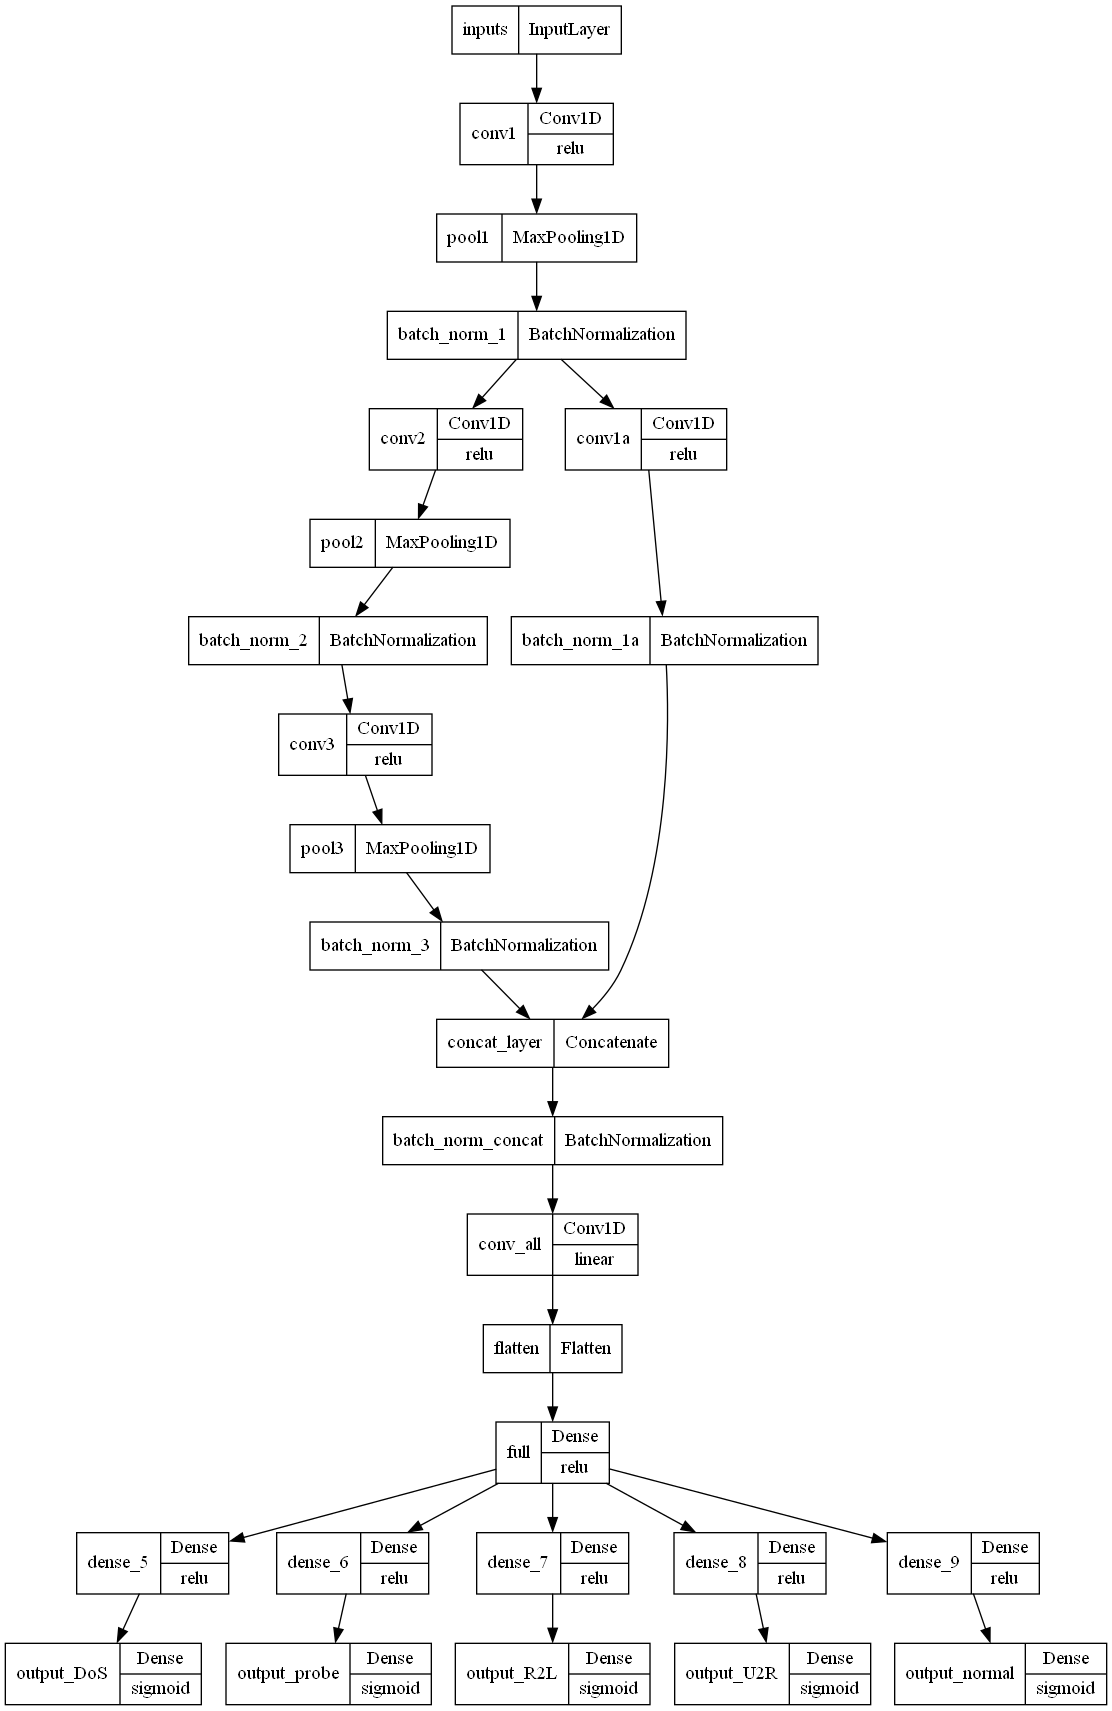

In [51]:
from keras.utils.vis_utils import plot_model
dot_img_file = 'lasso_elastic_mtlkeras/model_3.png'
plot_model(mtl, to_file=dot_img_file, show_shapes=False,show_layer_activations=True,show_layer_names=True, show_dtype=False)

In [78]:
callbacks = mtl_callbacks()
mtl.fit(multi_x_try, [train_DoS, train_R2L, train_U2R, train_normal, train_probe], validation_data=(mtl_test_x_lasso,[test_DoS, test_R2L, test_U2R, test_normal, test_probe]),
    batch_size=128, epochs=100, callbacks=callbacks)
pred_multi_class = mtl.predict(mtl_test_x_lasso)

loss = {'output_DoS': BinaryCrossentropy(from_logits=False,label_smoothing=0.1), 'output_probe': BinaryCrossentropy(from_logits=False,label_smoothing=0.1), 
            'output_R2L': BinaryCrossentropy(from_logits=False,label_smoothing=0.1), 'output_U2R': BinaryCrossentropy(from_logits=False,label_smoothing=0.1), 
            'output_normal': BinaryCrossentropy(from_logits=False,label_smoothing=0.1)}
loss_weights = {'output_DoS': 3, 'output_probe': 3, 'output_R2L': 4, 'output_U2R': 4, 'output_normal': 3}
print(mtl.evaluate(mtl_test_x_lasso,[test_DoS, test_R2L, test_U2R, test_normal, test_probe]))

mtl.save('lasso_elastic_mtlkeras/mtl_model_second.h5')


Epoch 1/100
2626/2628 [============================>.] - ETA: 0s - loss: 1.0918 - output_DoS_loss: 0.0675 - output_probe_loss: 0.0620 - output_R2L_loss: 0.0380 - output_U2R_loss: 0.0806 - output_normal_loss: 0.0763 - output_DoS_accuracy: 0.9715 - output_DoS_recall_13: 0.9170 - output_DoS_precision_at_recall_10: 0.9884 - output_DoS_true_positives_13: 61624.0000 - output_DoS_true_negatives_13: 264940.0000 - output_DoS_false_positives_13: 3989.0000 - output_DoS_false_negatives_13: 5575.0000 - output_probe_accuracy: 0.9804 - output_probe_recall_13: 0.9458 - output_probe_precision_at_recall_10: 0.9835 - output_probe_true_positives_13: 63620.0000 - output_probe_true_negatives_13: 265925.0000 - output_probe_false_positives_13: 2935.0000 - output_probe_false_negatives_13: 3648.0000 - output_R2L_accuracy: 0.9872 - output_R2L_recall_13: 0.9911 - output_R2L_precision_at_recall_10: 0.9816 - output_R2L_true_positives_13: 66709.0000 - output_R2L_true_negatives_13: 265129.0000 - output_R2L_false_posi

In [79]:

pred_multi = load_model('lasso_elastic_mtlkeras/mtl_model_second.h5')

pred_multi_class = pred_multi.predict(mtl_test_x_lasso)

loss = {'output_DoS': BinaryCrossentropy(from_logits=False,label_smoothing=0.1), 'output_probe': BinaryCrossentropy(from_logits=False,label_smoothing=0.1), 
            'output_R2L': BinaryCrossentropy(from_logits=False,label_smoothing=0.1), 'output_U2R': BinaryCrossentropy(from_logits=False,label_smoothing=0.1), 
            'output_normal': BinaryCrossentropy(from_logits=False,label_smoothing=0.1)}
loss_weights = {'output_DoS': 3, 'output_probe': 3, 'output_R2L': 4, 'output_U2R': 4, 'output_normal': 3}
pred_multi.compile(Adam(learning_rate=0.0001),loss=loss,loss_weights=loss_weights,
                   metrics=['accuracy',k_recall(thresholds=0.5), PrecisionAtRecall(recall=0.8), tp(thresholds=0.5), tn(thresholds=0.5), fp(thresholds=0.5), fn(thresholds=0.5)])
evaluation_values = pred_multi.evaluate(mtl_test_x_lasso,[test_DoS, test_R2L, test_U2R, test_normal, test_probe])
print(evaluation_values)

705/705 [==============================] - 6s 4ms/step - loss: 15.4263 - output_DoS_loss: 1.4467 - output_probe_loss: 1.5679 - output_R2L_loss: 0.0604 - output_U2R_loss: 1.1162 - output_normal_loss: 0.5586 - output_DoS_accuracy: 0.9027 - output_DoS_recall_14: 0.7330 - output_DoS_precision_at_recall_11: 0.8185 - output_DoS_true_positives_14: 5468.0000 - output_DoS_true_negatives_14: 14883.0000 - output_DoS_false_positives_14: 201.0000 - output_DoS_false_negatives_14: 1992.0000 - output_probe_accuracy: 0.8684 - output_probe_recall_14: 0.1657 - output_probe_precision_at_recall_11: 0.1328 - output_probe_true_positives_14: 478.0000 - output_probe_true_negatives_14: 19100.0000 - output_probe_false_positives_14: 559.0000 - output_probe_false_negatives_14: 2407.0000 - output_R2L_accuracy: 0.9939 - output_R2L_recall_14: 0.3881 - output_R2L_precision_at_recall_11: 0.0030 - output_R2L_true_positives_14: 26.0000 - output_R2L_true_negatives_14: 22381.0000 - output_R2L_false_positives_14: 96.0000 - 

In [80]:
def rates(tp, tn, fp, fn):
	acc = (tp+tn)/(tp+fp+tn+fn)
	precision = tp/(tp+fp)
	recall = tp/(tp+fn)
	tpr = tp/(tp+fn)
	fpr = fp/(fp+tn)
	print(f"Accuracy\t {acc:.4f} \nPrecision\t {precision:.4f} \nRecall\t {recall:.4f} \nFPR\t {fpr:.4f} \nTPR\t {tpr:.4f} \nTrue cases:\t {tp} \nFalse cases:\t {fp}")

for i in range(5):
	idx = ['matrix_DoS', 'matrix_R2L', 'matrix_U2R', 'matrix_normal', 'matrix_probe']
	print(idx[i])
	rates(evaluation_values[9+7*i],evaluation_values[10+7*i],evaluation_values[11+7*i],evaluation_values[12+7*i])


matrix_DoS
Accuracy	 0.9027 
Precision	 0.9645 
Recall	 0.7330 
FPR	 0.0133 
TPR	 0.7330 
True cases:	 5468.0 
False cases:	 201.0
matrix_R2L
Accuracy	 0.8684 
Precision	 0.4609 
Recall	 0.1657 
FPR	 0.0284 
TPR	 0.1657 
True cases:	 478.0 
False cases:	 559.0
matrix_U2R
Accuracy	 0.9939 
Precision	 0.2131 
Recall	 0.3881 
FPR	 0.0043 
TPR	 0.3881 
True cases:	 26.0 
False cases:	 96.0
matrix_normal
Accuracy	 0.8282 
Precision	 0.7364 
Recall	 0.9364 
FPR	 0.2536 
TPR	 0.9364 
True cases:	 9093.0 
False cases:	 3255.0
matrix_probe
Accuracy	 0.9242 
Precision	 0.6282 
Recall	 0.7204 
FPR	 0.0513 
TPR	 0.7204 
True cases:	 1744.0 
False cases:	 1032.0


### test optimized loss weights

In [87]:
from keras import initializers
def create_mtl_network_alt(input_dim=7):
    inputs = Input(shape=(input_dim,1), name='inputs')
    # First Convolution --original settings: 128,256,256,128
    conv1 = Conv1D(filters=256, kernel_size=5, padding='valid', activation='relu', name='conv1')(inputs)
    pool1 = MaxPooling1D(pool_size=3, name='pool1')(conv1)
    pool1 = BatchNormalization(name = 'batch_norm_1')(pool1)
    conv1a = Conv1D(filters=256, kernel_size=1, activation='relu', name='conv1a')(pool1)
    conv1a = BatchNormalization(name = 'batch_norm_1a')(conv1a)
    conv2 = Conv1D(filters=512, kernel_size=1, padding='same', activation='relu', name='conv2')(pool1)
    pool2 = MaxPooling1D(pool_size=1, name='pool2')(conv2)
    pool2 = BatchNormalization(name = 'batch_norm_2')(pool2)
    conv3 = Conv1D(filters=256, kernel_size=1, padding='same', activation='relu', name='conv3')(pool2)
    pool3 = MaxPooling1D(pool_size=1, name='pool3')(conv3)
    pool3 = BatchNormalization(name = 'batch_norm_3')(pool3)
    #combine and flatten --original settings: 128
    concat = Concatenate(axis=-1, name='concat_layer')([conv1a, pool3])
    concat = BatchNormalization(name = 'batch_norm_concat')(concat)
    conv_all = Conv1D(filters=256, kernel_size=1, padding="valid",name='conv_all')(concat)
    flatten = Flatten(name='flatten')(conv_all)
    full = Dense(1024, activation='relu', name='full')(flatten)
    #split
    net_DoS = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(full)
    output_DoS = Dense(1, activation='sigmoid', name='output_DoS')(net_DoS)
    net_probe = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(full)
    output_probe = Dense(1, activation='sigmoid', name='output_probe')(net_probe)
    net_R2L = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(full)
    output_R2L = Dense(1, activation='sigmoid', name='output_R2L')(net_R2L)
    net_U2R = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(full)
    output_U2R = Dense(1, activation='sigmoid', name='output_U2R')(net_U2R)
    net_normal = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(full)
    output_normal = Dense(1, activation='sigmoid', name='output_normal')(net_normal)

    model = Model(inputs=inputs, outputs=[output_DoS, output_probe, output_R2L, output_U2R, output_normal])
    value = [0.08944226827912863, 0.09061930572772953, 0.07437448099700576, 0.09253412802773642, 0.09532397935872657]
    loss = {'output_DoS': BinaryCrossentropy(from_logits=False), 'output_probe': BinaryCrossentropy(from_logits=False), 
                'output_R2L': BinaryCrossentropy(from_logits=False), 'output_U2R': BinaryCrossentropy(from_logits=False), 
                'output_normal': BinaryCrossentropy(from_logits=False)}
    loss_weights = {'output_DoS': value[0], 'output_R2L': value[1], 'output_U2R': value[2], 'output_normal': value[3], 'output_probe': value[4]}
    model.compile(Adam(learning_rate=0.001),loss=loss,loss_weights=loss_weights,
                    metrics=['accuracy',k_recall(thresholds=0.5), PrecisionAtRecall(recall=0.8), tp(thresholds=0.5), tn(thresholds=0.5), fp(thresholds=0.5), fn(thresholds=0.5)]
    )
    return model
mtl_alt = create_mtl_network_alt()

In [89]:
mtl_alt.fit(multi_x_try, [train_DoS, train_R2L, train_U2R, train_normal, train_probe], validation_data=(mtl_test_x_lasso,[test_DoS, test_R2L, test_U2R, test_normal, test_probe]),
    batch_size=128, epochs=100, callbacks=EarlyStopping(monitor='val_output_U2R_recall_18', patience=3, verbose=1))
pred_multi_class = mtl_alt.predict(mtl_test_x_lasso)

print(mtl_alt.evaluate(mtl_test_x_lasso,[test_DoS, test_R2L, test_U2R, test_normal, test_probe]))

mtl_alt.save('lasso_elastic_mtlkeras/mtl_model_second_alt_weight.h5')

Epoch 1/100
2628/2628 [==============================] - 58s 22ms/step - loss: 0.0281 - output_DoS_loss: 0.0665 - output_probe_loss: 0.0619 - output_R2L_loss: 0.0374 - output_U2R_loss: 0.0805 - output_normal_loss: 0.0747 - output_DoS_accuracy: 0.9722 - output_DoS_recall_18: 0.9186 - output_DoS_precision_at_recall_14: 0.9894 - output_DoS_true_positives_18: 61762.0000 - output_DoS_true_negatives_18: 265207.0000 - output_DoS_false_positives_18: 3864.0000 - output_DoS_false_negatives_18: 5472.0000 - output_probe_accuracy: 0.9804 - output_probe_recall_18: 0.9457 - output_probe_precision_at_recall_14: 0.9841 - output_probe_true_positives_18: 63658.0000 - output_probe_true_negatives_18: 266068.0000 - output_probe_false_positives_18: 2927.0000 - output_probe_false_negatives_18: 3652.0000 - output_R2L_accuracy: 0.9876 - output_R2L_recall_18: 0.9911 - output_R2L_precision_at_recall_14: 0.9829 - output_R2L_true_positives_18: 66746.0000 - output_R2L_true_negatives_18: 265392.0000 - output_R2L_fals

In [90]:
pred_alt = load_model('lasso_elastic_mtlkeras/mtl_model_second_alt_weight.h5')
pred_alt_class = pred_alt.predict(mtl_test_x_lasso)
evaluation_alt = pred_alt.evaluate(mtl_test_x_lasso,[test_DoS, test_R2L, test_U2R, test_normal, test_probe])
print(evaluation_alt)

705/705 [==============================] - 5s 5ms/step - loss: 0.5206 - output_DoS_loss: 1.6926 - output_probe_loss: 2.1152 - output_R2L_loss: 0.1009 - output_U2R_loss: 1.3756 - output_normal_loss: 0.6063 - output_DoS_accuracy: 0.9066 - output_DoS_recall_18: 0.7694 - output_DoS_precision_at_recall_14: 0.3337 - output_DoS_true_positives_18: 5740.0000 - output_DoS_true_negatives_18: 14699.0000 - output_DoS_false_positives_18: 385.0000 - output_DoS_false_negatives_18: 1720.0000 - output_probe_accuracy: 0.8791 - output_probe_recall_18: 0.1456 - output_probe_precision_at_recall_14: 0.1341 - output_probe_true_positives_18: 420.0000 - output_probe_true_negatives_18: 19398.0000 - output_probe_false_positives_18: 261.0000 - output_probe_false_negatives_18: 2465.0000 - output_R2L_accuracy: 0.9940 - output_R2L_recall_18: 0.4776 - output_R2L_precision_at_recall_14: 0.0033 - output_R2L_true_positives_18: 32.0000 - output_R2L_true_negatives_18: 22377.0000 - output_R2L_false_positives_18: 100.0000 - 

In [91]:
for i in range(5):
	idx = ['matrix_DoS', 'matrix_R2L', 'matrix_U2R', 'matrix_normal', 'matrix_probe']
	print(idx[i])
	rates(evaluation_alt[9+7*i],evaluation_alt[10+7*i],evaluation_alt[11+7*i],evaluation_alt[12+7*i])

matrix_DoS
Accuracy	 0.9066 
Precision	 0.9371 
Recall	 0.7694 
FPR	 0.0255 
TPR	 0.7694 
True cases:	 5740.0 
False cases:	 385.0
matrix_R2L
Accuracy	 0.8791 
Precision	 0.6167 
Recall	 0.1456 
FPR	 0.0133 
TPR	 0.1456 
True cases:	 420.0 
False cases:	 261.0
matrix_U2R
Accuracy	 0.9940 
Precision	 0.2424 
Recall	 0.4776 
FPR	 0.0044 
TPR	 0.4776 
True cases:	 32.0 
False cases:	 100.0
matrix_normal
Accuracy	 0.7889 
Precision	 0.6863 
Recall	 0.9392 
FPR	 0.3249 
TPR	 0.9392 
True cases:	 9121.0 
False cases:	 4170.0
matrix_probe
Accuracy	 0.9336 
Precision	 0.7405 
Recall	 0.5869 
FPR	 0.0247 
TPR	 0.5869 
True cases:	 1421.0 
False cases:	 498.0
